### In this script, DBN is run on synthetic data
### In this script, DBN is run with 1s time bin, 3 time lag 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
import scipy
import string
import warnings
import pickle
import copy

import os
import glob
import random
from time import time

from ana_functions.draw_self_loop import draw_self_loop
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection

from pgmpy.models import BayesianModel
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch,BicScore
from pgmpy.base import DAG
import networkx as nx


### function - train the dynamic bayesian network - multi time lag (3 lags)

In [2]:
from ana_functions.train_DBN_multiLag import train_DBN_multiLag
from ana_functions.train_DBN_multiLag import train_DBN_multiLag_create_df_only
from ana_functions.train_DBN_multiLag import train_DBN_multiLag_training_only
from ana_functions.train_DBN_multiLag import graph_to_matrix
from ana_functions.train_DBN_multiLag import get_weighted_dags
from ana_functions.train_DBN_multiLag import get_significant_edges
from ana_functions.train_DBN_multiLag import threshold_edges
from ana_functions.train_DBN_multiLag import Modulation_Index
from ana_functions.EfficientTimeShuffling import EfficientShuffle
from ana_functions.AicScore import AicScore

## DBN on the synthetic data

In [3]:
# where to save the summarizing data
data_saved_folder = '/gpfs/gibbs/pi/jadi/VideoTracker_SocialInter/3d_recontruction_analysis_self_and_coop_task_data_saved/'

### prepare the synthetic data for DBN

In [4]:
# ntimepoint_synth = 5*600*1 # estimate for a 5 sessions (600s long) combined data
ntimepoint_synth = 15*600*1 # estimate for a 5 sessions (600s long) combined data

eventnames = ['pull1','pull2','gaze1','gaze2']
nevents = np.shape(eventnames)[0]

# edge probability for behavioral events
# rows: from node; column: to nodes
if 0:
    edgeProb_3lag = np.array([[0.0, 0.1, 0.9, 0.5],
                              [0.0, 0.0, 0.6, 0.0],
                              [0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.6, 0.0, 0.0]])
    edgeProb_2lag = np.array([[0.0, 0.9, 0.2, 0.0],
                              [0.0, 0.0, 0.0, 0.4],
                              [0.7, 0.0, 0.0, 0.0],
                              [0.0, 0.7, 0.0, 0.0]])
    edgeProb_1lag = np.array([[0.0, 0.0, 0.0, 0.4],
                              [0.0, 0.0, 0.9, 0.0],
                              [0.0, 0.7, 0.0, 0.0],
                              [0.2, 0.0, 0.5, 0.0]])
    # low probability
    animal1_fixedorder = ['Diversed'] 
    animal2_fixedorder = ['Prob']
if 0:
    edgeProb_3lag = np.array([[0.0, 0.1, 0.3, 0.2],
                              [0.0, 0.0, 0.2, 0.0],
                              [0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.2, 0.0, 0.0]])
    edgeProb_2lag = np.array([[0.0, 0.3, 0.2, 0.0],
                              [0.0, 0.0, 0.0, 0.1],
                              [0.2, 0.0, 0.0, 0.0],
                              [0.0, 0.2, 0.0, 0.0]])
    edgeProb_1lag = np.array([[0.0, 0.0, 0.0, 0.1],
                              [0.0, 0.0, 0.3, 0.0],
                              [0.0, 0.2, 0.0, 0.0],
                              [0.1, 0.0, 0.2, 0.0]])
    # low probability
    animal1_fixedorder = ['Low'] 
    animal2_fixedorder = ['Prob']
if 0:
    edgeProb_3lag = np.array([[0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.0, 0.0, 0.0]])
    edgeProb_2lag = np.array([[0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.0, 0.0, 0.0]])
    edgeProb_1lag = np.array([[0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.0, 0.0, 0.0]])
    # low probability
    #animal1_fixedorder = ['AllZeroOne'] 
    #animal2_fixedorder = ['andRandom']
    animal1_fixedorder = ['All'] 
    animal2_fixedorder = ['Zero']
if 1:
    edgeProb_3lag_twoconds = dict.fromkeys(['synth_data_self','synth_data_coop'],[])    
    edgeProb_2lag_twoconds = dict.fromkeys(['synth_data_self','synth_data_coop'],[])
    edgeProb_1lag_twoconds = dict.fromkeys(['synth_data_self','synth_data_coop'],[])
    #
    edgeProb_3lag_twoconds['synth_data_self'] = np.array([ [0.0, 0.0, 0.2, 0.0],
                                                           [0.0, 0.0, 0.0, 0.0],
                                                           [0.0, 0.0, 0.0, 0.0],
                                                           [0.0, 0.0, 0.0, 0.0]])
    edgeProb_2lag_twoconds['synth_data_self'] = np.array([ [0.0, 0.0, 0.0, 0.0],
                                                           [0.0, 0.0, 0.0, 0.0],
                                                           [0.2, 0.0, 0.0, 0.0],
                                                           [0.0, 0.2, 0.0, 0.0]])
    edgeProb_1lag_twoconds['synth_data_self'] = np.array([ [0.0, 0.0, 0.2, 0.0],
                                                           [0.0, 0.0, 0.0, 0.2],
                                                           [0.0, 0.0, 0.0, 0.0],
                                                           [0.0, 0.0, 0.0, 0.0]])
    #
    edgeProb_3lag_twoconds['synth_data_coop'] = np.array([ [0.0, 0.0, 0.0, 0.2],
                                                           [0.0, 0.0, 0.2, 0.0],
                                                           [0.0, 0.0, 0.0, 0.0],
                                                           [0.0, 0.0, 0.0, 0.0]])
    edgeProb_2lag_twoconds['synth_data_coop'] = np.array([ [0.0, 0.0, 0.0, 0.0],
                                                           [0.0, 0.0, 0.0, 0.0],
                                                           [0.0, 0.2, 0.0, 0.0],
                                                           [0.2, 0.0, 0.0, 0.0]])
    edgeProb_1lag_twoconds['synth_data_coop'] = np.array([ [0.0, 0.2, 0.0, 0.0],
                                                           [0.0, 0.0, 0.0, 0.0],
                                                           [0.0, 0.0, 0.0, 0.0],
                                                           [0.0, 0.0, 0.0, 0.0]])
    # low probability
    animal1_fixedorder = ['FakeSelf'] 
    animal2_fixedorder = ['andFakeCoop_longdata_lowProb']
    

# DBN_group_typenames = ['synth_data_1','synth_data_2','synth_data_3']
# DBN_group_typenames = ['synth_data_all0','synth_data_all1','synth_data_random']
# DBN_group_typenames = ['synth_data_all0']
DBN_group_typenames = ['synth_data_self','synth_data_coop']
nDBN_groups = np.shape(DBN_group_typenames)[0]
DBN_input_data_synth = dict.fromkeys(DBN_group_typenames,[])

#pgazes_all = [0.05,0.01,0.001] # estimate based on Eddie/Sparkle: gaze time ~ 27s gaze in a 600s session
#ppulls_all = [0.05,0.01,0.001] # estimate based on Eddie/Sparkle: 150 pulls in a 600s (18,000 frames) session
pgazes_all = [0.04,0.04] # estimate based on Eddie/Sparkle: gaze time ~ 27s gaze in a 600s session
ppulls_all = [0.04,0.04] # estimate based on Eddie/Sparkle: 150 pulls in a 600s (18,000 frames) session
# pgazes_all = [0,0] # estimate based on Eddie/Sparkle: gaze time ~ 27s gaze in a 600s session
# ppulls_all = [0,0] # estimate based on Eddie/Sparkle: 150 pulls in a 600s (18,000 frames) session


for igroup in np.arange(0,nDBN_groups,1):
    
    DBNgroup_name = DBN_group_typenames[igroup]
    pgazes = pgazes_all[igroup]
    ppulls = ppulls_all[igroup]
    
    if 1:
        edgeProb_3lag = edgeProb_3lag_twoconds[DBNgroup_name]
        edgeProb_2lag = edgeProb_2lag_twoconds[DBNgroup_name]
        edgeProb_1lag = edgeProb_1lag_twoconds[DBNgroup_name]
    
    # initialize the trace
    pull1_synth_init = (np.random.rand(ntimepoint_synth)<ppulls).astype(int)
    pull2_synth_init = (np.random.rand(ntimepoint_synth)<ppulls).astype(int)
    gaze1_synth_init = (np.random.rand(ntimepoint_synth)<pgazes).astype(int)
    gaze2_synth_init = (np.random.rand(ntimepoint_synth)<pgazes).astype(int)
    #
    alltrace_synth = dict.fromkeys(eventnames,[])
    alltrace_synth['pull1'] = copy.deepcopy(pull1_synth_init)
    alltrace_synth['pull2'] = copy.deepcopy(pull2_synth_init)
    alltrace_synth['gaze1'] = copy.deepcopy(gaze1_synth_init)
    alltrace_synth['gaze2'] = copy.deepcopy(gaze2_synth_init)
    
    
    
    # using 3s sliding time window to turn on the events (to reflect the edges)
    for ievent in np.arange(0,nevents,1):
        # ievent: from event nodes
        ieventname = eventnames[ievent]
        for jevent in np.arange(0,nevents,1):
            # jevent: to event nodes
            jeventname = eventnames[jevent]
            #
            trace_synth_i = alltrace_synth[ieventname]
            trace_synth_j = alltrace_synth[jeventname]
            #

            # 3s sliding time window
            for itwin in np.arange(0,ntimepoint_synth-3,1):
                # 3s lag
                p_sample = np.random.rand(1)[0]
                if (p_sample < edgeProb_3lag[ievent,jevent]) & ((trace_synth_i[itwin]==1)):
                    trace_synth_i[itwin] = 1
                    trace_synth_j[itwin+3] = 1
                #else:
                #    trace_synth_i[itwin] = 0
                #    trace_synth_j[itwin+3] = 0
                # 2s lag
                p_sample = np.random.rand(1)[0]
                if (p_sample < edgeProb_2lag[ievent,jevent]) & ((trace_synth_i[itwin]==1)):
                    trace_synth_i[itwin] = 1
                    trace_synth_j[itwin+2] = 1
                #else:
                #    trace_synth_i[itwin] = 0
                #    trace_synth_j[itwin+2] = 0
                # 1s lag
                p_sample = np.random.rand(1)[0]
                if (p_sample < edgeProb_1lag[ievent,jevent]) & ((trace_synth_i[itwin]==1)):
                    trace_synth_i[itwin] = 1
                    trace_synth_j[itwin+1] = 1
                #else:
                #    trace_synth_i[itwin] = 0
                #    trace_synth_j[itwin+1] = 0

            alltrace_synth[ieventname] = trace_synth_i
            alltrace_synth[jeventname] = trace_synth_j

    pull1_synth_final = alltrace_synth['pull1']
    pull2_synth_final = alltrace_synth['pull2'] 
    gaze1_synth_final = alltrace_synth['gaze1']
    gaze2_synth_final = alltrace_synth['gaze2']

    # same function used 
    time_point_pull1 = pd.DataFrame(np.where(pull1_synth_final)[0])
    time_point_pull2 = pd.DataFrame(np.where(pull2_synth_final)[0])
    oneway_gaze1 = np.where(gaze1_synth_final)[0]
    oneway_gaze2 = np.where(gaze2_synth_final)[0]
    mutual_gaze1 = np.array([])
    mutual_gaze2 = np.array([])
    bhv_df_itr,_,_ = train_DBN_multiLag_create_df_only(ntimepoint_synth,0,1,time_point_pull1,time_point_pull2,oneway_gaze1,oneway_gaze2,mutual_gaze1,mutual_gaze2)


    DBN_input_data_synth[DBNgroup_name] = bhv_df_itr

print(np.sum(pull1_synth_final)/ntimepoint_synth)
print(np.sum(pull2_synth_final)/ntimepoint_synth)
print(np.sum(gaze1_synth_final)/ntimepoint_synth)
print(np.sum(gaze2_synth_final)/ntimepoint_synth)

0.050666666666666665
0.05477777777777778
0.049
0.048666666666666664


### run the DBN model on the synthetic data

In [5]:
# run DBN on the large table with merged sessions

mergetempRos = 0 # 1: merge different time bins

moreSampSize = 1 # 1: use more sample size (more than just minimal row number and max row number)

num_starting_points = 10 # number of random starting points/graphs
nbootstraps = 9

try:
    # dumpy
    data_saved_subfolder = data_saved_folder+'data_saved_DBN_synth_data_3Lags/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(data_saved_subfolder):
        os.makedirs(data_saved_subfolder)
    if moreSampSize:
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

    else:
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
            DAGscores_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
            DAGscores_shuffled_diffTempRo_diffSampSize = pickle.load(f) 
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
            weighted_graphs_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
            weighted_graphs_shuffled_diffTempRo_diffSampSize = pickle.load(f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
            sig_edges_diffTempRo_diffSampSize = pickle.load(f)

except:
    if moreSampSize:
        # different data (down/re)sampling numbers
        samplingsizes = [5000,9000]
        # samplingsizes = np.arange(9000,9500,500)
        # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
        # samplingsizes = [100,500]
        # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
        samplingsizes_name = list(map(str, samplingsizes))
        nsamplings = np.shape(samplingsizes)[0]

    weighted_graphs_diffTempRo_diffSampSize = {}
    weighted_graphs_shuffled_diffTempRo_diffSampSize = {}
    sig_edges_diffTempRo_diffSampSize = {}
    DAGscores_diffTempRo_diffSampSize = {}
    DAGscores_shuffled_diffTempRo_diffSampSize = {}

    # temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
    ntemp_reses = np.shape(temp_resolus)[0]

    # try different temporal resolutions, remember to use the same settings as in the previous ones
    for temp_resolu in temp_resolus:

        DBN_input_data_alltypes = DBN_input_data_synth

                
        # only try two sample sizes - minimal row number (require data downsample) and maximal row number (require data upsample)
       
        if not moreSampSize:
            key_to_value_lengths = {k:len(v) for k, v in DBN_input_data_alltypes.items()}
            key_to_value_lengths_array = np.fromiter(key_to_value_lengths.values(),dtype=float)
            key_to_value_lengths_array[key_to_value_lengths_array==0]=np.nan
            min_samplesize = np.nanmin(key_to_value_lengths_array)
            min_samplesize = int(min_samplesize/100)*100
            max_samplesize = np.nanmax(key_to_value_lengths_array)
            max_samplesize = int(max_samplesize/100)*100
            samplingsizes = [min_samplesize,max_samplesize]
            samplingsizes_name = ['min_row_number','max_row_number']   
            nsamplings = np.shape(samplingsizes)[0]
            print(samplingsizes)
                
        # try different down/re-sampling size
        for jj in np.arange(0,nsamplings,1):
            
            isamplingsize = samplingsizes[jj]
            
            DAGs_alltypes = dict.fromkeys(DBN_group_typenames, [])
            DAGs_shuffle_alltypes = dict.fromkeys(DBN_group_typenames, [])
            DAGs_scores_alltypes = dict.fromkeys(DBN_group_typenames, [])
            DAGs_shuffle_scores_alltypes = dict.fromkeys(DBN_group_typenames, [])

            weighted_graphs_alltypes = dict.fromkeys(DBN_group_typenames, [])
            weighted_graphs_shuffled_alltypes = dict.fromkeys(DBN_group_typenames, [])
            sig_edges_alltypes = dict.fromkeys(DBN_group_typenames, [])

            # different session conditions (aka DBN groups)
            for iDBN_group in np.arange(0,nDBN_groups,1):
                iDBN_group_typename = DBN_group_typenames[iDBN_group] 
                
                try:
                    bhv_df_all = DBN_input_data_alltypes[iDBN_group_typename]
                    # bhv_df = bhv_df_all.sample(30*100,replace = True, random_state = round(time())) # take the subset for DBN training

                    #Anirban(Alec) shuffle, slow
                    # bhv_df_shuffle, df_shufflekeys = EfficientShuffle(bhv_df,round(time()))


                    # define DBN graph structures; make sure they are the same as in the train_DBN_multiLag
                    colnames = list(bhv_df_all.columns)
                    eventnames = ["pull1","pull2","owgaze1","owgaze2"]
                    nevents = np.size(eventnames)

                    all_pops = list(bhv_df_all.columns)
                    from_pops = [pop for pop in all_pops if not pop.endswith('t3')]
                    to_pops = [pop for pop in all_pops if pop.endswith('t3')]
                    causal_whitelist = [(from_pop,to_pop) for from_pop in from_pops for to_pop in to_pops]

                    nFromNodes = np.shape(from_pops)[0]
                    nToNodes = np.shape(to_pops)[0]

                    DAGs_randstart = np.zeros((num_starting_points, nFromNodes, nToNodes))
                    DAGs_randstart_shuffle = np.zeros((num_starting_points, nFromNodes, nToNodes))
                    score_randstart = np.zeros((num_starting_points))
                    score_randstart_shuffle = np.zeros((num_starting_points))

                    # step 1: randomize the starting point for num_starting_points times
                    for istarting_points in np.arange(0,num_starting_points,1):

                        # try different down/re-sampling size
                        bhv_df = bhv_df_all.sample(isamplingsize,replace = True, random_state = istarting_points) # take the subset for DBN training
                        aic = AicScore(bhv_df)

                        #Anirban(Alec) shuffle, slow
                        bhv_df_shuffle, df_shufflekeys = EfficientShuffle(bhv_df,round(time()))
                        aic_shuffle = AicScore(bhv_df_shuffle)

                        np.random.seed(istarting_points)
                        random.seed(istarting_points)
                        starting_edges = random.sample(causal_whitelist, np.random.randint(1,len(causal_whitelist)))
                        starting_graph = DAG()
                        starting_graph.add_nodes_from(nodes=all_pops)
                        starting_graph.add_edges_from(ebunch=starting_edges)

                        best_model,edges,DAGs = train_DBN_multiLag_training_only(bhv_df,starting_graph,colnames,eventnames,from_pops,to_pops)           
                        DAGs[0][np.isnan(DAGs[0])]=0

                        DAGs_randstart[istarting_points,:,:] = DAGs[0]
                        score_randstart[istarting_points] = aic.score(best_model)

                        # step 2: add the shffled data results
                        # shuffled bhv_df
                        best_model,edges,DAGs = train_DBN_multiLag_training_only(bhv_df_shuffle,starting_graph,colnames,eventnames,from_pops,to_pops)           
                        DAGs[0][np.isnan(DAGs[0])]=0

                        DAGs_randstart_shuffle[istarting_points,:,:] = DAGs[0]
                        score_randstart_shuffle[istarting_points] = aic_shuffle.score(best_model)

                    DAGs_alltypes[iDBN_group_typename] = DAGs_randstart 
                    DAGs_shuffle_alltypes[iDBN_group_typename] = DAGs_randstart_shuffle

                    DAGs_scores_alltypes[iDBN_group_typename] = score_randstart
                    DAGs_shuffle_scores_alltypes[iDBN_group_typename] = score_randstart_shuffle

                    weighted_graphs = get_weighted_dags(DAGs_alltypes[iDBN_group_typename],nbootstraps)
                    weighted_graphs_shuffled = get_weighted_dags(DAGs_shuffle_alltypes[iDBN_group_typename],nbootstraps)
                    sig_edges = get_significant_edges(weighted_graphs,weighted_graphs_shuffled)

                    weighted_graphs_alltypes[iDBN_group_typename] = weighted_graphs
                    weighted_graphs_shuffled_alltypes[iDBN_group_typename] = weighted_graphs_shuffled
                    sig_edges_alltypes[iDBN_group_typename] = sig_edges
                    
                except:
                    DAGs_alltypes[iDBN_group_typename] = [] 
                    DAGs_shuffle_alltypes[iDBN_group_typename] = []

                    DAGs_scores_alltypes[iDBN_group_typename] = []
                    DAGs_shuffle_scores_alltypes[iDBN_group_typename] = []

                    weighted_graphs_alltypes[iDBN_group_typename] = []
                    weighted_graphs_shuffled_alltypes[iDBN_group_typename] = []
                    sig_edges_alltypes[iDBN_group_typename] = []
                
            DAGscores_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = DAGs_scores_alltypes
            DAGscores_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = DAGs_shuffle_scores_alltypes

            weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = weighted_graphs_alltypes
            weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = weighted_graphs_shuffled_alltypes
            sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),samplingsizes_name[jj])] = sig_edges_alltypes

            
    # save data
    data_saved_subfolder = data_saved_folder+'data_saved_DBN_synth_data_3Lags/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
    if not os.path.exists(data_saved_subfolder):
        os.makedirs(data_saved_subfolder)
    if moreSampSize:  
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
            pickle.dump(DAGscores_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
            pickle.dump(DAGscores_shuffled_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
            pickle.dump(weighted_graphs_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
            pickle.dump(weighted_graphs_shuffled_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'_moreSampSize.pkl', 'wb') as f:
            pickle.dump(sig_edges_diffTempRo_diffSampSize, f)

    else:
        with open(data_saved_subfolder+'/DAGscores_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(DAGscores_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/DAGscores_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(DAGscores_shuffled_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/weighted_graphs_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(weighted_graphs_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/weighted_graphs_shuffled_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(weighted_graphs_shuffled_diffTempRo_diffSampSize, f)
        with open(data_saved_subfolder+'/sig_edges_diffTempRo_diffSampSize_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(sig_edges_diffTempRo_diffSampSize, f)


### plot graphs - show the edge with arrows; show the best time bin and row number; show the three time lag separately

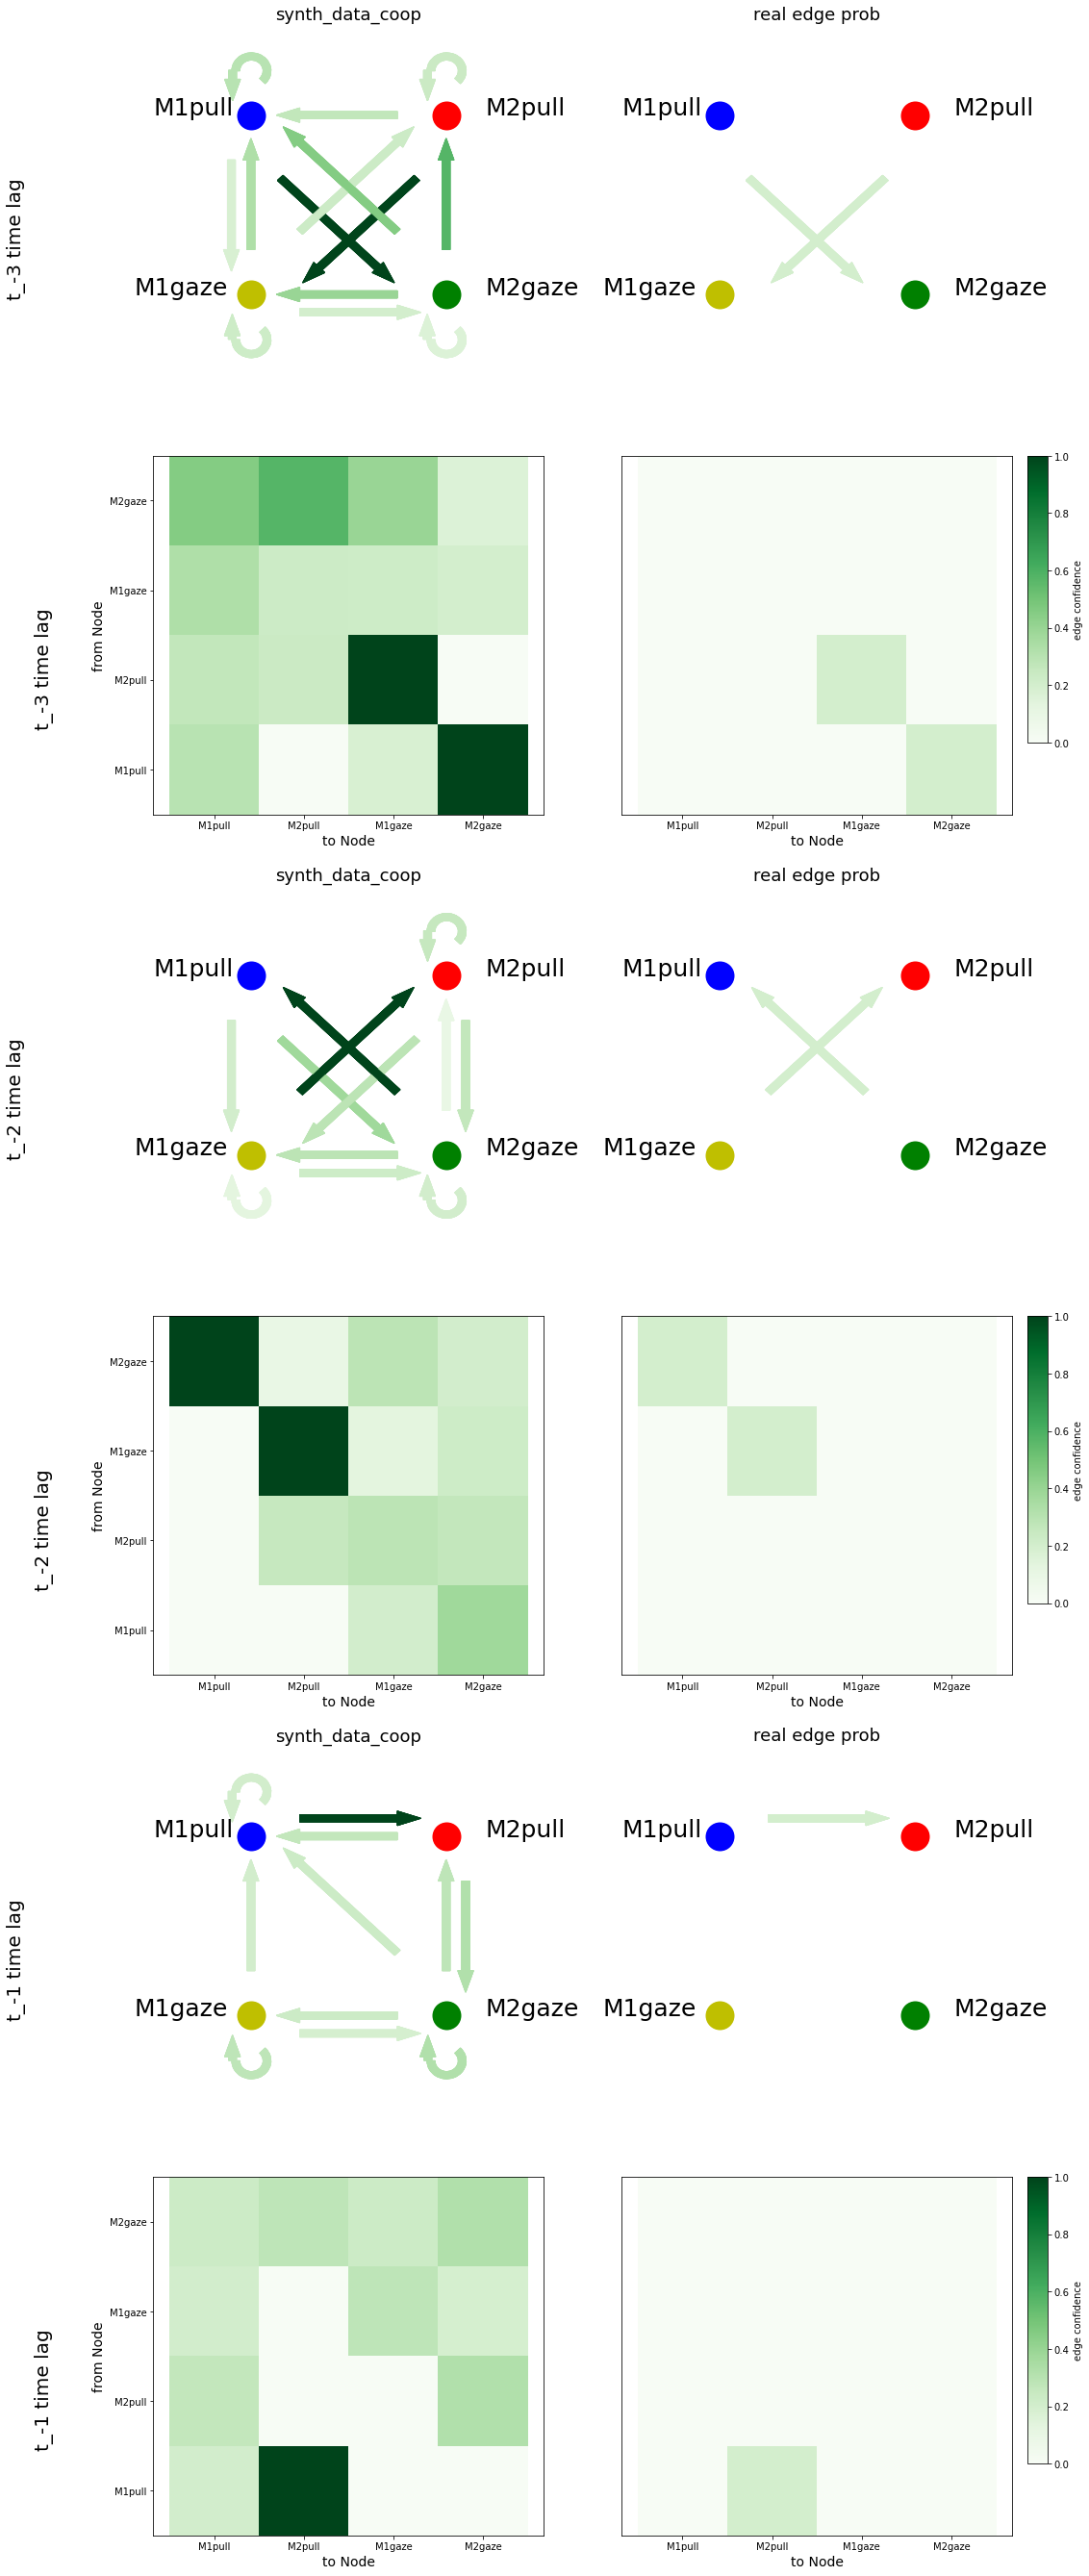

In [6]:
# make sure these variables are the same as in the previous steps
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]
#
if moreSampSize:
    # different data (down/re)sampling numbers
    # samplingsizes = np.arange(1100,3000,100)
    samplingsizes = [9000]
    # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
    # samplingsizes = [100,500]
    # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
    samplingsizes_name = list(map(str, samplingsizes))
else:
    samplingsizes_name = ['min_row_number']   
nsamplings = np.shape(samplingsizes_name)[0]

# settings for plots
# DBN_group_typenames = ['synth_data_1']
# DBN_group_typenames = ['synth_data_all0']
DBN_group_typenames = ['synth_data_coop']
nDBN_groups = np.shape(DBN_group_typenames)[0]


# make sure these variables are consistent with the train_DBN_alec.py settings
# eventnames = ["pull1","pull2","gaze1","gaze2"]
eventnames = ["M1pull","M2pull","M1gaze","M2gaze"]
eventnode_locations = [[0,1],[1,1],[0,0],[1,0]]
eventname_locations = [[-0.5,1.0],[1.2,1],[-0.6,0],[1.2,0]]
# indicate where edge starts
# for the self edge, it's the center of the self loop
nodearrow_locations = [[[0.00,1.25],[0.25,1.10],[-.10,0.75],[0.15,0.65]],
                       [[0.75,1.00],[1.00,1.25],[0.85,0.65],[1.10,0.75]],
                       [[0.00,0.25],[0.25,0.35],[0.00,-.25],[0.25,-.10]],
                       [[0.75,0.35],[1.00,0.25],[0.75,0.00],[1.00,-.25]]]
# indicate where edge goes
# for the self edge, it's the theta1 and theta2 (with fixed radius)
nodearrow_directions = [[[ -45,-180],[0.50,0.00],[0.00,-.50],[0.50,-.50]],
                        [[-.50,0.00],[ -45,-180],[-.50,-.50],[0.00,-.50]],
                        [[0.00,0.50],[0.50,0.50],[ 180,  45],[0.50,0.00]],
                        [[-.50,0.50],[0.00,0.50],[-.50,0.00],[ 180,  45]]]

nevents = np.size(eventnames)
eventnodes_color = ['b','r','y','g']
    
savefigs = 0

# different session conditions (aka DBN groups)
# different time lags (t_-3, t_-2 and t_-1)
fig, axs = plt.subplots(6,nDBN_groups+1)
fig.set_figheight(48)
fig.set_figwidth(8*(nDBN_groups+1))

time_lags = ['t_-3','t_-2','t_-1']
fromRowIDs =[[0,1,2,3],[4,5,6,7],[8,9,10,11]]
ntime_lags = np.shape(time_lags)[0]

temp_resolu = temp_resolus[0]
j_sampsize_name = samplingsizes_name[0]    


# add the real probability figure
edgeProb_real = np.concatenate((edgeProb_3lag,edgeProb_2lag,edgeProb_1lag))
# edgeProb_real = edgeProb_real*3.33

for ilag in np.arange(0,ntime_lags,1):
    
    time_lag_name = time_lags[ilag]
    fromRowID = fromRowIDs[ilag]
    
    for iDBN_group in np.arange(0,nDBN_groups+1,1):
        
        if 0:
            edgeProb_3lag = edgeProb_3lag_twoconds[DBN_group_typenames[0]]
            edgeProb_2lag = edgeProb_2lag_twoconds[DBN_group_typenames[0]]
            edgeProb_1lag = edgeProb_1lag_twoconds[DBN_group_typenames[0]]

        try:
            if iDBN_group < nDBN_groups:
                iDBN_group_typename = DBN_group_typenames[iDBN_group]

                weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][iDBN_group_typename]
                sig_edges_tgt = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][iDBN_group_typename]

                sig_avg_dags = weighted_graphs_tgt.mean(axis = 0) * sig_edges_tgt
                sig_avg_dags = sig_avg_dags[fromRowID,:]
            else:
                iDBN_group_typename = 'real edge prob'
                sig_avg_dags = edgeProb_real[fromRowID,:]

            # plot
            axs[ilag*2+0,iDBN_group].set_title(iDBN_group_typename,fontsize=18)
            axs[ilag*2+0,iDBN_group].set_xlim([-0.5,1.5])
            axs[ilag*2+0,iDBN_group].set_ylim([-0.5,1.5])
            axs[ilag*2+0,iDBN_group].set_xticks([])
            axs[ilag*2+0,iDBN_group].set_xticklabels([])
            axs[ilag*2+0,iDBN_group].set_yticks([])
            axs[ilag*2+0,iDBN_group].set_yticklabels([])
            axs[ilag*2+0,iDBN_group].spines['top'].set_visible(False)
            axs[ilag*2+0,iDBN_group].spines['right'].set_visible(False)
            axs[ilag*2+0,iDBN_group].spines['bottom'].set_visible(False)
            axs[ilag*2+0,iDBN_group].spines['left'].set_visible(False)
            # axs[ilag*2+0,iDBN_group].axis('equal')

            
            for ieventnode in np.arange(0,nevents,1):
                # plot the event nodes
                axs[ilag*2+0,iDBN_group].plot(eventnode_locations[ieventnode][0],eventnode_locations[ieventnode][1],'.',markersize=60,markerfacecolor=eventnodes_color[ieventnode],markeredgecolor='none')              
                axs[ilag*2+0,iDBN_group].text(eventname_locations[ieventnode][0],eventname_locations[ieventnode][1],
                                       eventnames[ieventnode],fontsize=25)
                
                clmap = mpl.cm.get_cmap('Greens')
                
                # plot the event edges
                for ifromNode in np.arange(0,nevents,1):
                    for itoNode in np.arange(0,nevents,1):
                        edge_weight_tgt = sig_avg_dags[ifromNode,itoNode]
                        if edge_weight_tgt>0:
                            if not ifromNode == itoNode:
                                #axs[ilag*2+0,iDBN_group].plot(eventnode_locations[ifromNode],eventnode_locations[itoNode],'k-',linewidth=edge_weight_tgt*3)
                                axs[ilag*2+0,iDBN_group].arrow(nodearrow_locations[ifromNode][itoNode][0],
                                                        nodearrow_locations[ifromNode][itoNode][1],
                                                        nodearrow_directions[ifromNode][itoNode][0],
                                                        nodearrow_directions[ifromNode][itoNode][1],
                                                        #head_width=0.08*abs(edge_weight_tgt),
                                                        #width=0.04*abs(edge_weight_tgt),
                                                        head_width=0.08,
                                                        width=0.04,
                                                        color = clmap(edge_weight_tgt))
                            if ifromNode == itoNode:
                                ring = mpatches.Wedge(nodearrow_locations[ifromNode][itoNode],
                                                      .1, nodearrow_directions[ifromNode][itoNode][0],
                                                      nodearrow_directions[ifromNode][itoNode][1], 
                                                      # 0.04*abs(edge_weight_tgt),
                                                      0.04,
                                                      color = clmap(edge_weight_tgt))
                                p = PatchCollection(
                                    [ring], 
                                    facecolor=clmap(edge_weight_tgt), 
                                    edgecolor=clmap(edge_weight_tgt)
                                )
                                axs[ilag*2+0,iDBN_group].add_collection(p)
                                # add arrow head
                                if ifromNode < 2:
                                    axs[ilag*2+0,iDBN_group].arrow(nodearrow_locations[ifromNode][itoNode][0]-0.1+0.02*edge_weight_tgt,
                                                            nodearrow_locations[ifromNode][itoNode][1],
                                                            0,-0.05,color=clmap(edge_weight_tgt),
                                                            # head_width=0.08*edge_weight_tgt,width=0.04*edge_weight_tgt
                                                            head_width=0.08,width=0.04      
                                                            )
                                else:
                                    axs[ilag*2+0,iDBN_group].arrow(nodearrow_locations[ifromNode][itoNode][0]-0.1+0.02*edge_weight_tgt,
                                                            nodearrow_locations[ifromNode][itoNode][1],
                                                            0,0.02,color=clmap(edge_weight_tgt),
                                                            #head_width=0.08*edge_weight_tgt,width=0.04*edge_weight_tgt
                                                            head_width=0.08,width=0.04      
                                                            )

            # heatmap for the weights
            sig_avg_dags_df = pd.DataFrame(sig_avg_dags)
            sig_avg_dags_df.columns = eventnames
            sig_avg_dags_df.index = eventnames
            vmin,vmax = 0,1
            import matplotlib as mpl
            norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
            im = axs[ilag*2+1,iDBN_group].pcolormesh(sig_avg_dags_df,cmap="Greens",norm=norm)
            #
            if iDBN_group == nDBN_groups:
                cax = axs[ilag*2+1,iDBN_group].inset_axes([1.04, 0.2, 0.05, 0.8])
                fig.colorbar(im, ax=axs[ilag*2+1,iDBN_group], cax=cax,label='edge confidence')

            axs[ilag*2+1,iDBN_group].axis('equal')
            axs[ilag*2+1,iDBN_group].set_xlabel('to Node',fontsize=14)
            axs[ilag*2+1,iDBN_group].set_xticks(np.arange(0.5,4.5,1))
            axs[ilag*2+1,iDBN_group].set_xticklabels(eventnames)
            if iDBN_group == 0:
                axs[ilag*2+1,iDBN_group].set_ylabel('from Node',fontsize=14)
                axs[ilag*2+1,iDBN_group].set_yticks(np.arange(0.5,4.5,1))
                axs[ilag*2+1,iDBN_group].set_yticklabels(eventnames)
                axs[ilag*2+1,iDBN_group].text(-1.5,1,time_lag_name+' time lag',rotation=90,fontsize=20)
                axs[ilag*2+0,iDBN_group].text(-1.25,0,time_lag_name+' time lag',rotation=90,fontsize=20)
            else:
                axs[ilag*2+1,iDBN_group].set_yticks([])
                axs[ilag*2+1,iDBN_group].set_yticklabels([])

        except:
            continue
    
if savefigs:
    if moreSampSize:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_Aniposelib3d_synthetic_data/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+"threeTimeLag_DAGs_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows.pdf')
    else:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_Aniposelib3d_synthetic_data/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+"threeTimeLag_DAGs_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_'+j_sampsize_name+'.pdf')
            
            
            

### plot graphs - show the edge with arrows; show the best time bin and row number; show the three time lag separately; modulation index plot for synth coop - synth self

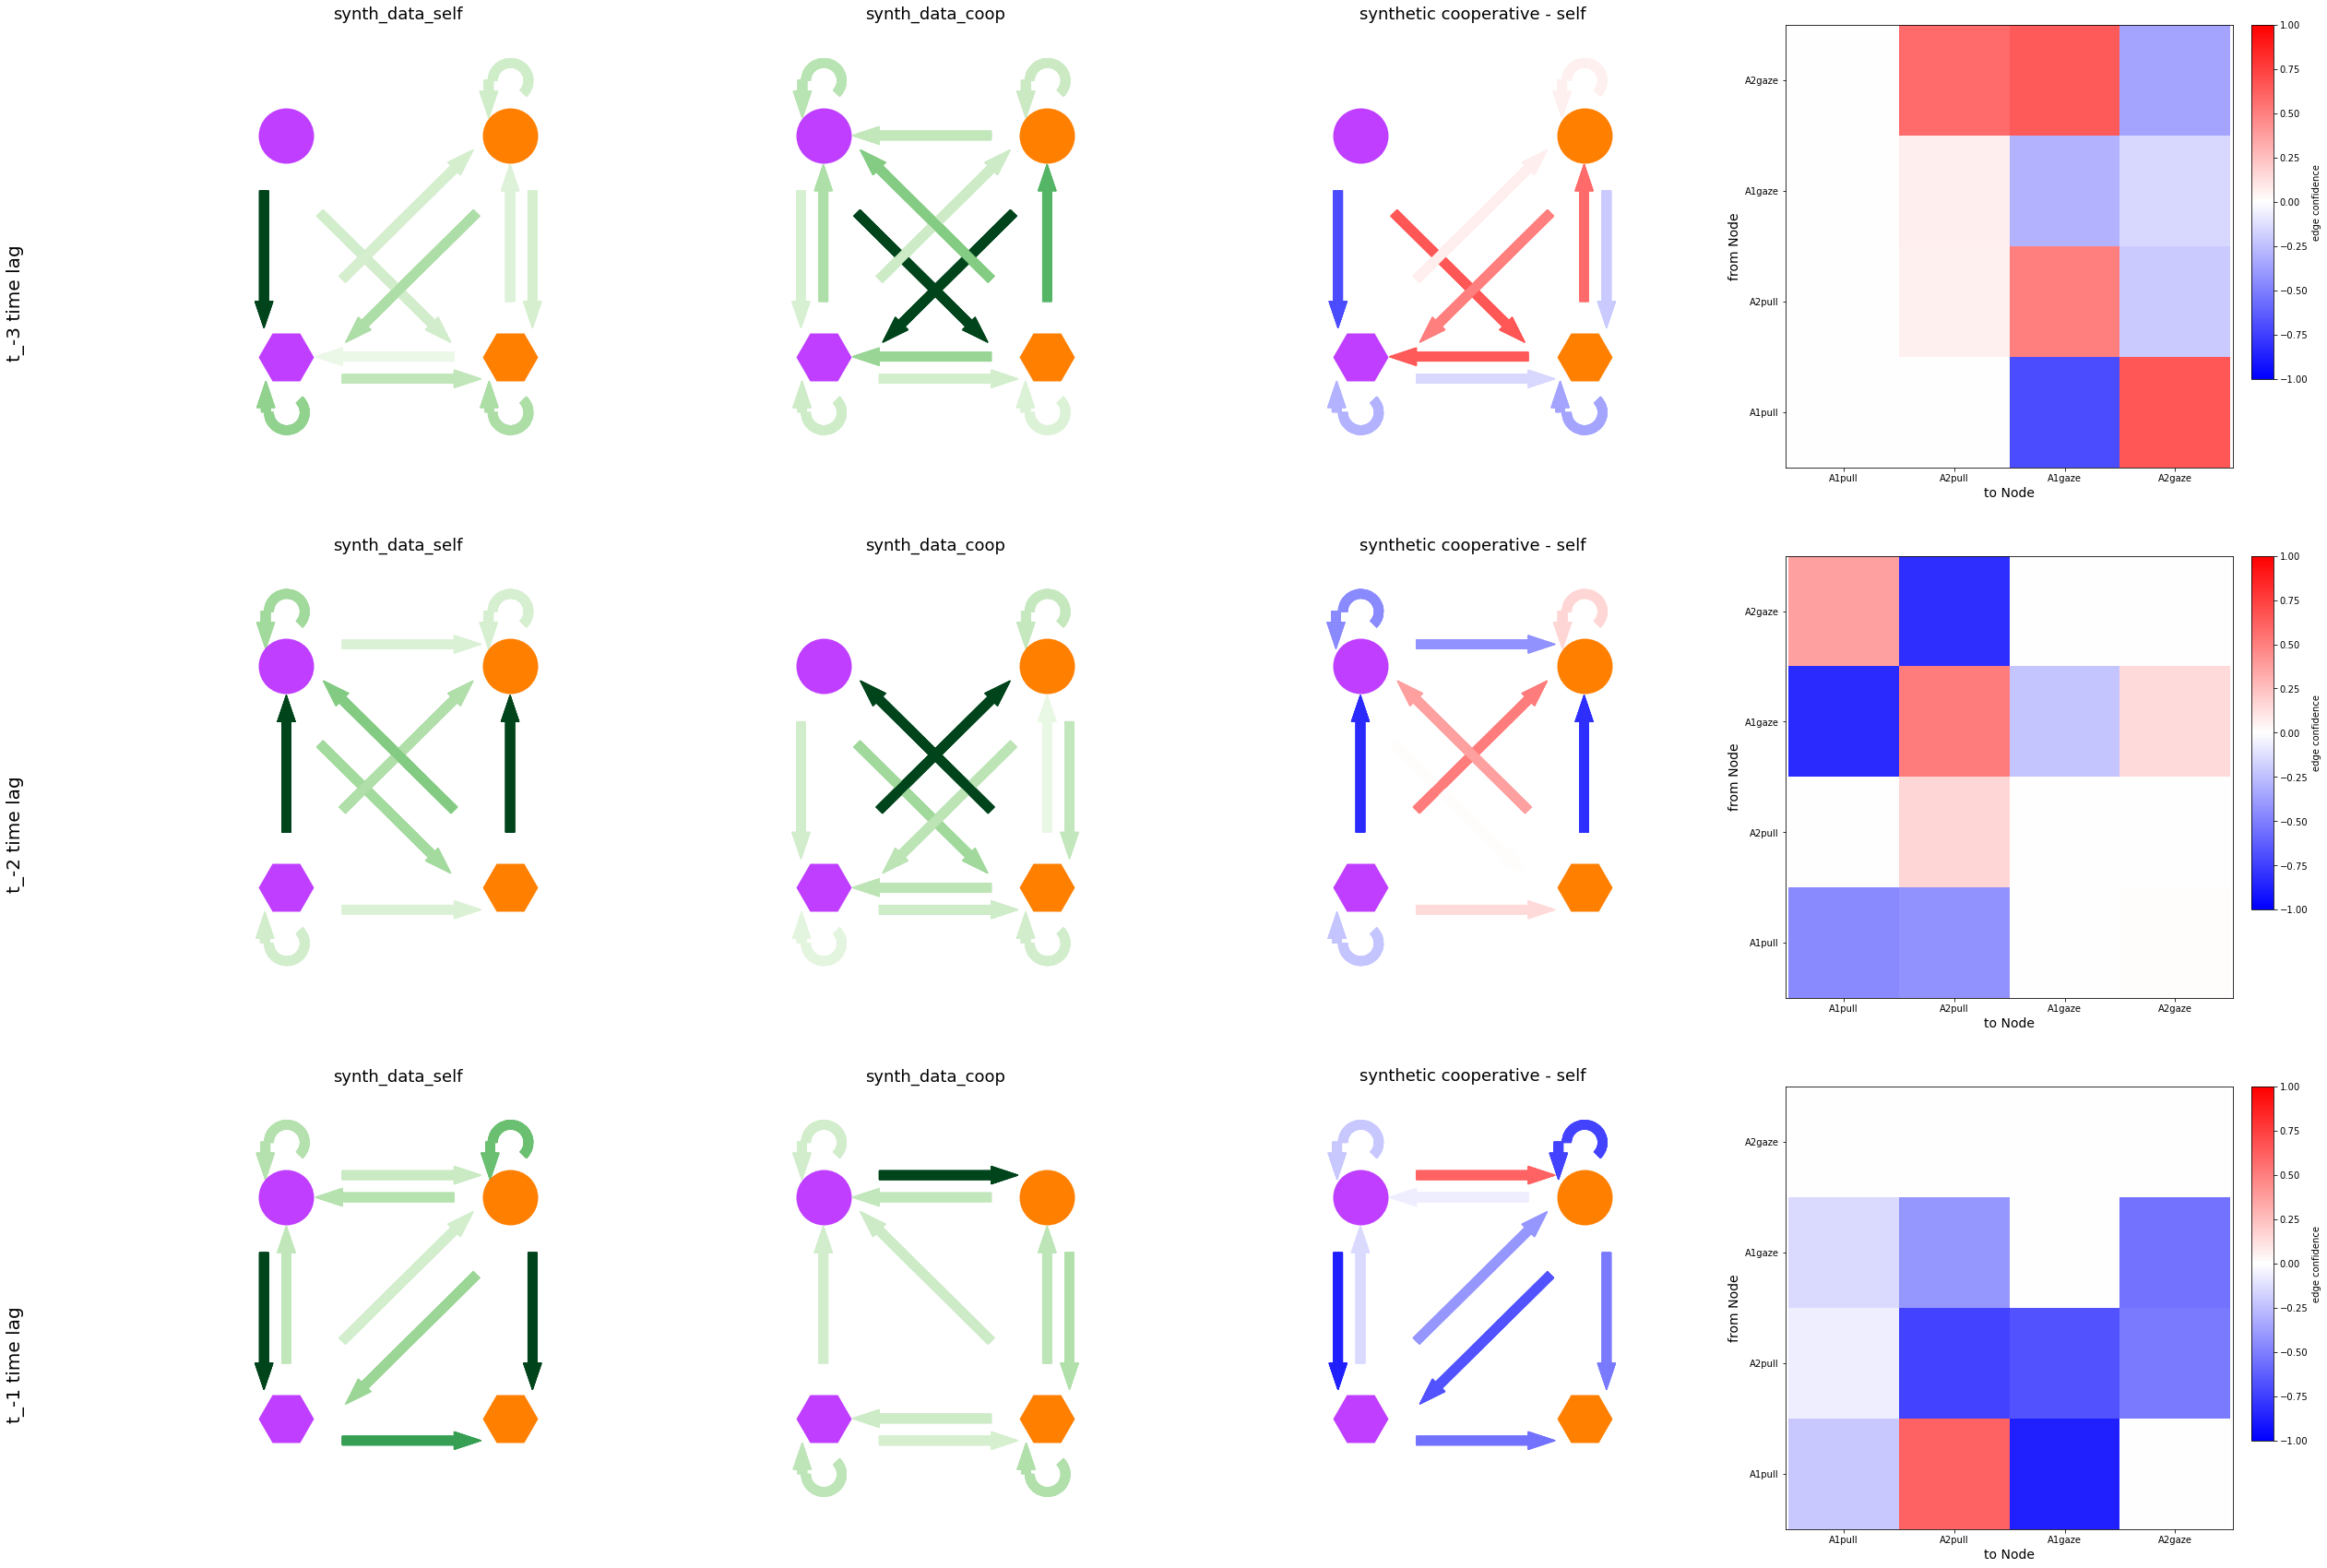

In [12]:
# make sure these variables are the same as in the previous steps
# temp_resolus = [0.5,1,1.5,2] # temporal resolution in the DBN model, eg: 0.5 means 500ms
temp_resolus = [1] # temporal resolution in the DBN model, eg: 0.5 means 500ms
ntemp_reses = np.shape(temp_resolus)[0]
#
if moreSampSize:
    # different data (down/re)sampling numbers
    # samplingsizes = np.arange(1100,3000,100)
    samplingsizes = [9000]
    # samplingsizes = [100,500,1000,1500,2000,2500,3000]        
    # samplingsizes = [100,500]
    # samplingsizes_name = ['100','500','1000','1500','2000','2500','3000']
    samplingsizes_name = list(map(str, samplingsizes))
else:
    samplingsizes_name = ['min_row_number']   
nsamplings = np.shape(samplingsizes_name)[0]

# settings for plots
# DBN_group_typenames = ['synth_data_1']
# DBN_group_typenames = ['synth_data_random']
DBN_group_typenames = ['synth_data_self','synth_data_coop']
nDBN_groups = np.shape(DBN_group_typenames)[0]


# make sure these variables are consistent with the train_DBN_alec.py settings
# eventnames = ["pull1","pull2","gaze1","gaze2"]
eventnames = ["A1pull","A2pull","A1gaze","A2gaze"]
eventnode_locations = [[0,1],[1,1],[0,0],[1,0]]
eventname_locations = [[-0.5,1.0],[1.2,1],[-0.6,0],[1.2,0]]
# indicate where edge starts
# for the self edge, it's the center of the self loop
nodearrow_locations = [[[0.00,1.25],[0.25,1.10],[-.10,0.75],[0.15,0.65]],
                       [[0.75,1.00],[1.00,1.25],[0.85,0.65],[1.10,0.75]],
                       [[0.00,0.25],[0.25,0.35],[0.00,-.25],[0.25,-.10]],
                       [[0.75,0.35],[1.00,0.25],[0.75,0.00],[1.00,-.25]]]
# indicate where edge goes
# for the self edge, it's the theta1 and theta2 (with fixed radius)
nodearrow_directions = [[[ -45,-180],[0.50,0.00],[0.00,-.50],[0.50,-.50]],
                        [[-.50,0.00],[ -45,-180],[-.50,-.50],[0.00,-.50]],
                        [[0.00,0.50],[0.50,0.50],[ 180,  45],[0.50,0.00]],
                        [[-.50,0.50],[0.00,0.50],[-.50,0.00],[ 180,  45]]]

nevents = np.size(eventnames)
# eventnodes_color = ['b','r','y','g']
eventnodes_color = ['#BF3EFF','#FF7F00','#BF3EFF','#FF7F00']
eventnodes_shape = ["o","o","H","H"]
    
savefigs = 0

# different session conditions (aka DBN groups)
# different time lags (t_-3, t_-2 and t_-1)
fig, axs = plt.subplots(3,nDBN_groups+2)
fig.set_figheight(30)
fig.set_figwidth(10*(nDBN_groups+2))

time_lags = ['t_-3','t_-2','t_-1']
fromRowIDs =[[0,1,2,3],[4,5,6,7],[8,9,10,11]]
ntime_lags = np.shape(time_lags)[0]

temp_resolu = temp_resolus[0]
j_sampsize_name = samplingsizes_name[0]    


# add the real probability figure
edgeProb_real = np.concatenate((edgeProb_3lag,edgeProb_2lag,edgeProb_1lag))
edgeProb_real = edgeProb_real*3.33

for ilag in np.arange(0,ntime_lags,1):
    
    time_lag_name = time_lags[ilag]
    fromRowID = fromRowIDs[ilag]
    
    for iDBN_group in np.arange(0,nDBN_groups,1):
        
            iDBN_group_typename = DBN_group_typenames[iDBN_group]

            weighted_graphs_tgt = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][iDBN_group_typename]
            weighted_graphs_shuffled_tgt = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][iDBN_group_typename]
            # sig_edges_tgt = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)][iDBN_group_typename]
            sig_edges_tgt = get_significant_edges(weighted_graphs_tgt,weighted_graphs_shuffled_tgt)
           
            # sig_edges_tgt = sig_edges_tgt*((weighted_graphs_tgt.mean(axis=0)>0.5)*1)

            sig_avg_dags = weighted_graphs_tgt.mean(axis = 0) * sig_edges_tgt
            sig_avg_dags = sig_avg_dags[fromRowID,:]
 
            # plot
            axs[ilag,iDBN_group].set_title(iDBN_group_typename,fontsize=18)
            axs[ilag,iDBN_group].set_xlim([-0.5,1.5])
            axs[ilag,iDBN_group].set_ylim([-0.5,1.5])
            axs[ilag,iDBN_group].set_xticks([])
            axs[ilag,iDBN_group].set_xticklabels([])
            axs[ilag,iDBN_group].set_yticks([])
            axs[ilag,iDBN_group].set_yticklabels([])
            axs[ilag,iDBN_group].spines['top'].set_visible(False)
            axs[ilag,iDBN_group].spines['right'].set_visible(False)
            axs[ilag,iDBN_group].spines['bottom'].set_visible(False)
            axs[ilag,iDBN_group].spines['left'].set_visible(False)
            # axs[ilag*2+0,iDBN_group].axis('equal')
            
            if iDBN_group == 0:
                axs[ilag,iDBN_group].text(-1.25,0,time_lag_name+' time lag',rotation=90,fontsize=20)

            
            for ieventnode in np.arange(0,nevents,1):
                # plot the event nodes
                axs[ilag,iDBN_group].plot(eventnode_locations[ieventnode][0],eventnode_locations[ieventnode][1],eventnodes_shape[ieventnode],
                                          markersize=60,markerfacecolor=eventnodes_color[ieventnode],markeredgecolor='none')              
                #axs[ilag,iDBN_group].text(eventname_locations[ieventnode][0],eventname_locations[ieventnode][1],
                #                      eventnames[ieventnode],fontsize=25)
                
                clmap = mpl.cm.get_cmap('Greens')
                
                # plot the event edges
                for ifromNode in np.arange(0,nevents,1):
                    for itoNode in np.arange(0,nevents,1):
                        edge_weight_tgt = sig_avg_dags[ifromNode,itoNode]
                        if edge_weight_tgt>0:
                            if not ifromNode == itoNode:
                                #axs[ilag,iDBN_group].plot(eventnode_locations[ifromNode],eventnode_locations[itoNode],'k-',linewidth=edge_weight_tgt*3)
                                axs[ilag,iDBN_group].arrow(nodearrow_locations[ifromNode][itoNode][0],
                                                        nodearrow_locations[ifromNode][itoNode][1],
                                                        nodearrow_directions[ifromNode][itoNode][0],
                                                        nodearrow_directions[ifromNode][itoNode][1],
                                                        #head_width=0.08*abs(edge_weight_tgt),
                                                        #width=0.04*abs(edge_weight_tgt),
                                                        head_width=0.08,
                                                        width=0.04,
                                                        color = clmap(edge_weight_tgt))
                            if ifromNode == itoNode:
                                ring = mpatches.Wedge(nodearrow_locations[ifromNode][itoNode],
                                                      .1, nodearrow_directions[ifromNode][itoNode][0],
                                                      nodearrow_directions[ifromNode][itoNode][1], 
                                                      # 0.04*abs(edge_weight_tgt),
                                                      0.04,
                                                      color = clmap(edge_weight_tgt))
                                p = PatchCollection(
                                    [ring], 
                                    facecolor=clmap(edge_weight_tgt), 
                                    edgecolor=clmap(edge_weight_tgt)
                                )
                                axs[ilag,iDBN_group].add_collection(p)
                                # add arrow head
                                if ifromNode < 2:
                                    axs[ilag,iDBN_group].arrow(nodearrow_locations[ifromNode][itoNode][0]-0.1+0.02*edge_weight_tgt,
                                                            nodearrow_locations[ifromNode][itoNode][1],
                                                            0,-0.05,color=clmap(edge_weight_tgt),
                                                            # head_width=0.08*edge_weight_tgt,width=0.04*edge_weight_tgt
                                                            head_width=0.08,width=0.04      
                                                            )
                                else:
                                    axs[ilag,iDBN_group].arrow(nodearrow_locations[ifromNode][itoNode][0]-0.1+0.02*edge_weight_tgt,
                                                            nodearrow_locations[ifromNode][itoNode][1],
                                                            0,0.02,color=clmap(edge_weight_tgt),
                                                            #head_width=0.08*edge_weight_tgt,width=0.04*edge_weight_tgt
                                                            head_width=0.08,width=0.04      
                                                            )
                            
    
    # Modelation index 
    weighted_graphs_self = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['synth_data_self']
    weighted_graphs_shuffled_self = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['synth_data_self']    
    # sig_edges_self = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['synth_data_self']
    sig_edges_self = get_significant_edges(weighted_graphs_self,weighted_graphs_shuffled_self)
    #
    # sig_edges_self = sig_edges_self*((weighted_graphs_self.mean(axis=0)>0.5)*1)
    #
    weighted_graphs_coop = weighted_graphs_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['synth_data_coop']
    weighted_graphs_shuffled_coop = weighted_graphs_shuffled_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['synth_data_coop']
    # sig_edges_coop = sig_edges_diffTempRo_diffSampSize[(str(temp_resolu),j_sampsize_name)]['synth_data_coop']
    sig_edges_coop = get_significant_edges(weighted_graphs_coop,weighted_graphs_shuffled_coop)
    #
    # sig_edges_coop = sig_edges_coop*((weighted_graphs_coop.mean(axis=0)>0.5)*1)
    #
    weighted_graphs_self_mean = weighted_graphs_self.mean(axis=0)
    weighted_graphs_coop_mean = weighted_graphs_coop.mean(axis=0)
    #
    if 0:
        # weighted_graphs_delta = (weighted_graphs_coop_mean-weighted_graphs_self_mean)/(weighted_graphs_coop_mean+weighted_graphs_self_mean)
        # weighted_graphs_delta = (weighted_graphs_coop_mean-weighted_graphs_self_mean)
        # weighted_graphs_delta = (weighted_graphs_coop-weighted_graphs_self)/(weighted_graphs_coop+weighted_graphs_self)
        weighted_graphs_delta = (weighted_graphs_coop-weighted_graphs_self)
        weighted_graphs_delta = weighted_graphs_delta.mean(axis=0)
        #
        sig_edges_delta = ((sig_edges_self+sig_edges_self)>0)*1
    else:
        weighted_graphs_delta,sig_edges_delta = Modulation_Index(weighted_graphs_self, weighted_graphs_coop,
                                                                 sig_edges_self, sig_edges_self, 8000)
        weighted_graphs_delta = weighted_graphs_delta.mean(axis=0)
    #    
    sig_avg_dags = weighted_graphs_delta * sig_edges_delta
    sig_avg_dags = sig_avg_dags[fromRowID,:]
    
     
    # modulation edges
    axs[ilag,nDBN_groups].set_title('synthetic cooperative - self',fontsize=18)
    axs[ilag,nDBN_groups].set_xlim([-0.5,1.5])
    axs[ilag,nDBN_groups].set_ylim([-0.5,1.5])
    axs[ilag,nDBN_groups].set_xticks([])
    axs[ilag,nDBN_groups].set_xticklabels([])
    axs[ilag,nDBN_groups].set_yticks([])
    axs[ilag,nDBN_groups].set_yticklabels([])
    axs[ilag,nDBN_groups].spines['top'].set_visible(False)
    axs[ilag,nDBN_groups].spines['right'].set_visible(False)
    axs[ilag,nDBN_groups].spines['bottom'].set_visible(False)
    axs[ilag,nDBN_groups].spines['left'].set_visible(False)
    #
    for ieventnode in np.arange(0,nevents,1):
        # plot the event nodes
        axs[ilag,nDBN_groups].plot(eventnode_locations[ieventnode][0],eventnode_locations[ieventnode][1],eventnodes_shape[ieventnode],
                                   markersize=60,markerfacecolor=eventnodes_color[ieventnode],markeredgecolor='none')              
        #axs[ilag,nDBN_groups].text(eventname_locations[ieventnode][0],eventname_locations[ieventnode][1],
        #                       eventnames[ieventnode],fontsize=25)

        clmap = mpl.cm.get_cmap('bwr')

        # plot the event edges
        for ifromNode in np.arange(0,nevents,1):
            for itoNode in np.arange(0,nevents,1):
                edge_weight_tgt = sig_avg_dags[ifromNode,itoNode]
                #
                if not edge_weight_tgt == 0:
                    if not ifromNode == itoNode:
                        #axs[ilag,iDBN_group].plot(eventnode_locations[ifromNode],eventnode_locations[itoNode],'k-',linewidth=edge_weight_tgt*3)
                        axs[ilag,nDBN_groups].arrow(nodearrow_locations[ifromNode][itoNode][0],
                                                nodearrow_locations[ifromNode][itoNode][1],
                                                nodearrow_directions[ifromNode][itoNode][0],
                                                nodearrow_directions[ifromNode][itoNode][1],
                                                #head_width=0.08*abs(edge_weight_tgt),
                                                #width=0.04*abs(edge_weight_tgt),
                                                head_width=0.08,
                                                width=0.04,
                                                color = clmap((1+edge_weight_tgt)/2))
                    if ifromNode == itoNode:
                        ring = mpatches.Wedge(nodearrow_locations[ifromNode][itoNode],
                                              .1, nodearrow_directions[ifromNode][itoNode][0],
                                              nodearrow_directions[ifromNode][itoNode][1], 
                                              # 0.04*abs(edge_weight_tgt),
                                              0.04,
                                              color = clmap((1+edge_weight_tgt)/2))
                        p = PatchCollection(
                            [ring], 
                            facecolor=clmap((1+edge_weight_tgt)/2), 
                            edgecolor=clmap((1+edge_weight_tgt)/2)
                        )
                        axs[ilag,nDBN_groups].add_collection(p)
                        # add arrow head
                        if ifromNode < 2:
                            axs[ilag,nDBN_groups].arrow(nodearrow_locations[ifromNode][itoNode][0]-0.1+0.02*edge_weight_tgt,
                                                    nodearrow_locations[ifromNode][itoNode][1],
                                                    0,-0.05,color=clmap((1+edge_weight_tgt)/2),
                                                    # head_width=0.08*edge_weight_tgt,width=0.04*edge_weight_tgt
                                                    head_width=0.08,width=0.04      
                                                    )
                        else:
                            axs[ilag,nDBN_groups].arrow(nodearrow_locations[ifromNode][itoNode][0]-0.1+0.02*edge_weight_tgt,
                                                    nodearrow_locations[ifromNode][itoNode][1],
                                                    0,0.02,color=clmap((1+edge_weight_tgt)/2),
                                                    #head_width=0.08*edge_weight_tgt,width=0.04*edge_weight_tgt
                                                    head_width=0.08,width=0.04      
                                                    )
    
    # heatmap for the modulation inex
    sig_avg_dags_df = pd.DataFrame(sig_avg_dags)
    sig_avg_dags_df.columns = eventnames
    sig_avg_dags_df.index = eventnames
    vmin,vmax = -1,1
    import matplotlib as mpl
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    im = axs[ilag,nDBN_groups+1].pcolormesh(sig_avg_dags_df,cmap="bwr",norm=norm)
    #
    cax = axs[ilag,nDBN_groups+1].inset_axes([1.04, 0.2, 0.05, 0.8])
    fig.colorbar(im, ax=axs[ilag,nDBN_groups+1], cax=cax,label='edge confidence')

    axs[ilag,nDBN_groups+1].axis('equal')
    axs[ilag,nDBN_groups+1].set_xlabel('to Node',fontsize=14)
    axs[ilag,nDBN_groups+1].set_xticks(np.arange(0.5,4.5,1))
    axs[ilag,nDBN_groups+1].set_xticklabels(eventnames)
    
    axs[ilag,nDBN_groups+1].set_ylabel('from Node',fontsize=14)
    axs[ilag,nDBN_groups+1].set_yticks(np.arange(0.5,4.5,1))
    axs[ilag,nDBN_groups+1].set_yticklabels(eventnames)

    
if savefigs:
    if moreSampSize:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_Aniposelib3d_synthetic_data/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+"threeTimeLag_DAGs_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_'+str(j_sampsize_name)+'_rows_ModulationIndex.pdf')
    else:
        figsavefolder = data_saved_folder+'figs_for_3LagDBN_and_bhv_Aniposelib3d_synthetic_data/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'
        if not os.path.exists(figsavefolder):
            os.makedirs(figsavefolder)
        plt.savefig(figsavefolder+"threeTimeLag_DAGs_"+animal1_fixedorder[0]+animal2_fixedorder[0]+'_'+str(temp_resolu)+'_'+j_sampsize_name+'_ModulationIndex.pdf')
            
            
            